

# Alineamiento del setup del SLM

Este notebook sirve para ayudar en el alineamiento de los elementos de polarización del setup del SLM. En primer lugar, hay que tener alineada la parte del resto de elementos ópticos comunes (telescopios, SLM, fotodetectores, etc.). Entonces, podemos pasar a alinear P0 y Q0, y encontrar los ejes principales del resto de elementos.

## Preparativos

Importamos los módulos necesarios.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares

from py_pol.jones_matrix import Jones_matrix, Jones_vector

degrees = np.pi/180

from py_lab.daca import DACA, Close_All_DACA

In [2]:
# Crear el objeto de control de la tarjeta de adquisicion de datos
daca = DACA(name="U3")
daca.Open() # Comprobar que no esten cambiados

In [7]:
# Test de que funciona
daca.Get_Signal(verbose=True, return_ref=True, rest_background=False, use_ref=False)

Reference:  0.024319999999999453
Signal:  8.007455999999998


(8.007455999999998, 0.024319999999999453)

In [8]:
# Medir el background
daca.Get_Signal(is_background=True, verbose=True)

Reference:  0.024319999999999453
Signal:  0.05948799999999821


0.05948799999999821

Ahora, vamos a crear unas pocas funciones que serán necesarias durante los diversos pasos de alineamiento.

In [9]:
def cos2(param, x):
    """Funcion coseno cuadrado."""
    return param[0] + param[1] * np.cos(x - param[2])**2

def error_cos2(param, x, P):
    """Error de la funcion coseno cuadrado."""
    return P - cos2(param, x)

In [10]:
def cos2_2(param, x):
    """Funcion coseno cuadrado."""
    return param[0] + param[1] * np.cos(2*(x - param[2]))**2

def error_cos2_2(param, x, P):
    """Error de la funcion coseno cuadrado."""
    return P - cos2_2(param, x)

In [11]:
def pypol(param, x):
    """Funcion mas compleja."""
    E0 = Jones_vector().general_azimuth_ellipticity(intensity=param[0], azimuth=0, ellipticity=param[1])
    Q0 = Jones_matrix().retarder_linear(azimuth=45*degrees+param[4], R=param[2])
    P1 = Jones_matrix().diattenuator_perfect(azimuth=x-param[3])
    E = P1 * Q0 * E0
    return E.parameters.intensity()

def error_pypol(param, x, P):
    """Error de la funcion pypol."""
    return P - pypol(param, x)

In [12]:
def Tomar_Medidas(N=100, use_ref=True):
    """Funcion que sirve para tomar medidas angulo-potencia.
    
    Args:
        N (int): Numero maximo de medidas."""
    angulos = np.zeros(N)
    P = np.zeros(N)        
    
    for ind in range(N):
        ang = input('Angulo (en grados)')
        try:
            angulos[ind] = float(ang)
            P[ind] = daca.Get_Signal(use_ref=use_ref)
        except:
            if ang.lower() in ('fin', 'end', 'stop'):
                angulos = angulos[:ind]
                P = P[:ind]
                break
            else:
                print('Value {} not accepted'.format(ang))
            
    return angulos*degrees, P

default_bounds = ([0, 0, 0], [10, 10, 180*degrees])

def Analizar_medidas(angulos, P, fun_err=error_cos2, fun_plot=cos2, param_0=[3, 2, 0], bounds=default_bounds):
    """Funcion que sirve para analizar las medidas tomadas.
    
    Args:
        angulos (np.ndarray): Angulos a los que se han tomado las medidas.
        P (np.ndarray): Resultado de las medidas.
        fun_err (function): Funcion que calcula el error en los datos.
        fun_plot (function): Funcion a la que deberian ajustar los datos.
        param_0 (array like): Parametros iniciales para el algoritmo de ajuste.
        bounds (2x1 tuple): Limites para el algoritmo de ajuste."""
    # Ajustar
    result = least_squares(fun=fun_err, x0=param_0, args=[angulos, P], bounds=bounds)
    
    # Representar los resultados
    if len(result.x) == 3:
        print('Resultados:\n - Pmin = {:.3f}.\n - DP = {:.3f} V.\n - A_0 = {:.1f} deg.\n - Error: {:.3f}'.format(
            result.x[0], result.x[1], result.x[2] / degrees, result.cost))
    elif len(result.x) == 5:
        print('Resultados:\n - I0 = {:.3f}.\n - Ellipticity_E0 = {:.1f} deg.\n - Retardance_Q0 = {:.1f} deg.\n - Theta_0 = {:.1f} deg.\n - Q0 angle offset = {}\n - Error: {:.3f}'.format(
            result.x[0], np.abs(result.x[1]) / degrees, result.x[2] / degrees, result.x[3] / degrees, result.x[4]/degrees, result.cost))
    
    # Representar el resultado
    plt.figure()
    plt.plot(angulos/degrees, P, '+b', angulos/degrees, fun_plot(result.x, angulos), '--r')
    
    return result.x

# Tests de Iluminacion

Hemos visto una cosa rara, la Ley de Malus parece fallar. Vamos a investigarlo. Pongo solo la iluminación y un polarizador.

In [62]:
angulos, P = Tomar_Medidas()

Angulo (en grados) 10
Angulo (en grados) 20
Angulo (en grados) 30
Angulo (en grados) 40
Angulo (en grados) 50
Angulo (en grados) 60
Angulo (en grados) 70
Angulo (en grados) 80
Angulo (en grados) 90
Angulo (en grados) 100
Angulo (en grados) 110
Angulo (en grados) 120
Angulo (en grados) 130
Angulo (en grados) 140
Angulo (en grados) 150
Angulo (en grados) 160
Angulo (en grados) 170
Angulo (en grados) 180
Angulo (en grados) 190
Angulo (en grados) 200
Angulo (en grados) 210
Angulo (en grados) 220
Angulo (en grados) 230
Angulo (en grados) 240
Angulo (en grados) 250
Angulo (en grados) 260
Angulo (en grados) 270
Angulo (en grados) 280
Angulo (en grados) 290
Angulo (en grados) 300
Angulo (en grados) 310
Angulo (en grados) 320
Angulo (en grados) 330
Angulo (en grados) 340
Angulo (en grados) 350
Angulo (en grados) end


Resultados:
 - Pmin = 0.838.
 - DP = 0.215 V.
 - A_0 = 49.2 deg.
 - Error: 0.057


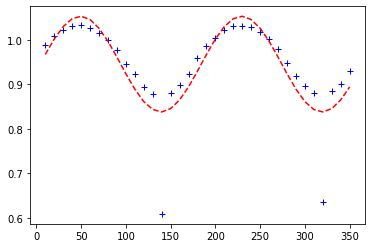

In [63]:
param_0 = [1.4, 0.3, 180*degrees*np.random.rand(1)[0]]
bounds = ([0, 0, 0], [2, 1, 180*degrees])
param_illum = Analizar_medidas(angulos, P, fun_err=error_cos2, fun_plot=cos2, param_0=param_0, bounds=bounds)

Casi bien, salvo por los minimos de 140 y 320º. Vamos a investigar eso en detalle.

In [64]:
angulos2, P2 = Tomar_Medidas()

Angulo (en grados) 130
Angulo (en grados) 132
Angulo (en grados) 134
Angulo (en grados) 136
Angulo (en grados) 138
Angulo (en grados) 140
Angulo (en grados) 142
Angulo (en grados) 144
Angulo (en grados) 146
Angulo (en grados) 148
Angulo (en grados) 150
Angulo (en grados) end


In [67]:
angulos3 = np.concatenate((angulos, angulos2))
P3 = np.concatenate((P, P2))

(120.0, 160.0)

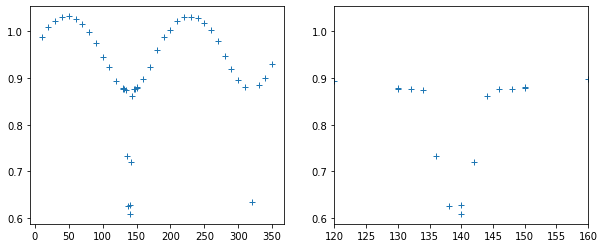

In [73]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(angulos3/degrees, P3, "+")
plt.subplot(1,2,2)
plt.plot(angulos3/degrees, P3, "+")
plt.xlim([120, 160])

No tiene sentido ese pico de anchura de 12º. Vamos a probar con un polarizador diferente.

In [74]:
angulos, P = Tomar_Medidas()

Angulo (en grados) 10
Angulo (en grados) 20
Angulo (en grados) 30
Angulo (en grados) 40
Angulo (en grados) 50
Angulo (en grados) 60
Angulo (en grados) 70
Angulo (en grados) 80
Angulo (en grados) 90
Angulo (en grados) 100
Angulo (en grados) 110
Angulo (en grados) 120
Angulo (en grados) 130
Angulo (en grados) 140
Angulo (en grados) 150
Angulo (en grados) 160
Angulo (en grados) 170
Angulo (en grados) 180
Angulo (en grados) 190
Angulo (en grados) 200
Angulo (en grados) 210
Angulo (en grados) 220
Angulo (en grados) 230
Angulo (en grados) 240
Angulo (en grados) 250
Angulo (en grados) 260
Angulo (en grados) 270
Angulo (en grados) 280
Angulo (en grados) 290
Angulo (en grados) 300
Angulo (en grados) 310
Angulo (en grados) 320
Angulo (en grados) 330
Angulo (en grados) 340
Angulo (en grados) 350
Angulo (en grados) end


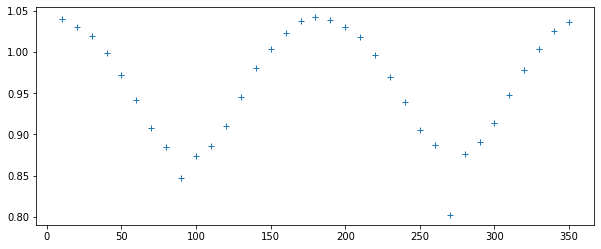

In [75]:
plt.figure(figsize=(10,4))
plt.plot(angulos/degrees, P, "+")

In [ ]:
param_0 = [1.4, 0.3, 180*degrees*np.random.rand(1)[0]]
bounds = ([0, 0, 0], [2, 1, 180*degrees])
param_illum = Analizar_medidas(angulos, P, fun_err=error_cos2, fun_plot=cos2, param_0=param_0, bounds=bounds)

Mejor pero siguen existiendo los picos. Voy a ver que pasa entre 260 y 280º.

In [76]:
angulos2, P2 = Tomar_Medidas()

Angulo (en grados) 260
Angulo (en grados) 262
Angulo (en grados) 264
Angulo (en grados) 266
Angulo (en grados) 268
Angulo (en grados) 270
Angulo (en grados) 272
Angulo (en grados) 274
Angulo (en grados) 276
Angulo (en grados) 278
Angulo (en grados) 280
Angulo (en grados) end


In [77]:
angulos3 = np.concatenate((angulos, angulos2))
P3 = np.concatenate((P, P2))

(260.0, 280.0)

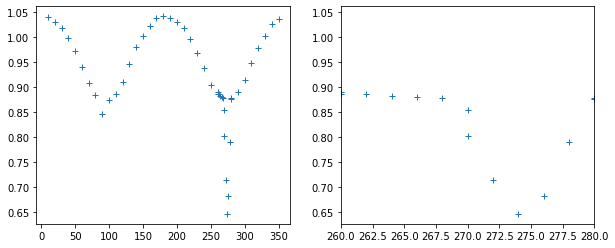

In [78]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(angulos3/degrees, P3, "+")
plt.subplot(1,2,2)
plt.plot(angulos3/degrees, P3, "+")
plt.xlim([260, 280])

Sigue existiendo el mismo problema. Vamos a ver que pasa si colocamos el polarizador de referencia antes del polarizador rotatorio. El Pref no esta en uno de esos minimos raros. Vamos a ver si podemos trabajar asi y la Ley de Malus no falla,

In [15]:
angulos, P = Tomar_Medidas()

Angulo (en grados) 10
Angulo (en grados) 20
Angulo (en grados) 30
Angulo (en grados) 40
Angulo (en grados) 50
Angulo (en grados) 60
Angulo (en grados) 70
Angulo (en grados) 80
Angulo (en grados) 90
Angulo (en grados) 100
Angulo (en grados) 110
Angulo (en grados) 120
Angulo (en grados) 130
Angulo (en grados) 140
Angulo (en grados) 150
Angulo (en grados) 160
Angulo (en grados) 170
Angulo (en grados) 180
Angulo (en grados) 190
Angulo (en grados) 200
Angulo (en grados) 210
Angulo (en grados) 220
Angulo (en grados) 230
Angulo (en grados) 240
Angulo (en grados) 250
Angulo (en grados) 260
Angulo (en grados) 270
Angulo (en grados) 280
Angulo (en grados) 290
Angulo (en grados) 300
Angulo (en grados) 310
Angulo (en grados) 320
Angulo (en grados) 330
Angulo (en grados) 340
Angulo (en grados) 350
Angulo (en grados) end


Resultados:
 - Pmin = 0.115.
 - DP = 0.910 V.
 - A_0 = 82.8 deg.
 - Error: 0.184


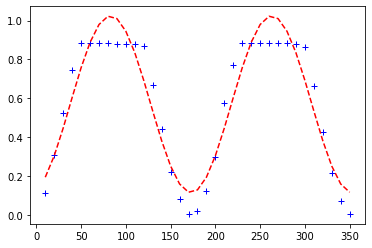

In [17]:
param_0 = [1.4, 0.3, 180*degrees*np.random.rand(1)[0]]
bounds = ([0, 0, 0], [2, 1, 180*degrees])
param_illum = Analizar_medidas(angulos, P, fun_err=error_cos2, fun_plot=cos2, param_0=param_0, bounds=bounds)

He realineado el laser. Vuelvo a probar con Pref y P1 girando.

In [29]:
angulos, P = Tomar_Medidas()

Angulo (en grados) 10


f:\codigo\py_lab\py_lab\daca.py:229: RuntimeWarning: divide by zero encountered in true_divide
  signal /= ref


KeyboardInterrupt: Interrupted by user

Resultados:
 - Pmin = 0.197.
 - DP = 0.850 V.
 - A_0 = 81.5 deg.
 - Error: 0.345


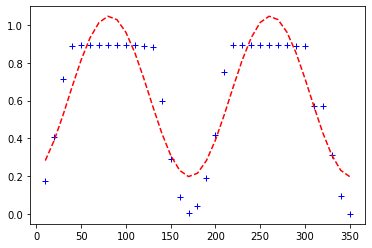

In [19]:
param_0 = [1.4, 0.3, 180*degrees*np.random.rand(1)[0]]
bounds = ([0, 0, 0], [2, 1, 180*degrees])
param_illum = Analizar_medidas(angulos, P, fun_err=error_cos2, fun_plot=cos2, param_0=param_0, bounds=bounds)

He quitado el telescopio para hacer Ley de Malus solo con laser y polarizador.

In [13]:
angulos, P = Tomar_Medidas(use_ref=False)

Angulo (en grados) 10
Angulo (en grados) 20
Angulo (en grados) 30
Angulo (en grados) 40
Angulo (en grados) 50
Angulo (en grados) 60
Angulo (en grados) 70
Angulo (en grados) 80
Angulo (en grados) 90
Angulo (en grados) 100
Angulo (en grados) 110
Angulo (en grados) 120
Angulo (en grados) 130
Angulo (en grados) 140
Angulo (en grados) 150
Angulo (en grados) 160
Angulo (en grados) 170
Angulo (en grados) 180
Angulo (en grados) 190
Angulo (en grados) 200
Angulo (en grados) 210
Angulo (en grados) 220
Angulo (en grados) 230
Angulo (en grados) 240
Angulo (en grados) 250
Angulo (en grados) 260
Angulo (en grados) 270
Angulo (en grados) 280
Angulo (en grados) 290
Angulo (en grados) 300
Angulo (en grados) 310
Angulo (en grados) 320
Angulo (en grados) 330
Angulo (en grados) 340
Angulo (en grados) 350
Angulo (en grados) end


Resultados:
 - Pmin = 0.000.
 - DP = 7.949 V.
 - A_0 = 4.2 deg.
 - Error: 0.074


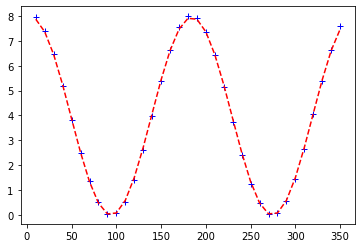

In [19]:
param_0 = [1.4, 0.3, 180*degrees*np.random.rand(1)[0]]
bounds = ([0, 0, 0], [9, 9, 180*degrees])
param_illum = Analizar_medidas(angulos, P, fun_err=error_cos2, fun_plot=cos2, param_0=param_0, bounds=bounds)

Parece que solo el laser funciona bien. El problema debe ser entonces el telescopio. Toca ver como arreglarlo.

A ojo claramente sigue ocurriendo el mismo efecto. Voy a repetir solo por tener la prueba. Por evitar posibles saturaciones, voy a hacer la medida si el fotodiodo de referencia.

In [20]:
angulos, P = Tomar_Medidas(use_ref=False)

Angulo (en grados) 10
Angulo (en grados) 20
Angulo (en grados) 30
Angulo (en grados) 40
Angulo (en grados) 50
Angulo (en grados) 60
Angulo (en grados) 70
Angulo (en grados) 80
Angulo (en grados) 90
Angulo (en grados) 100
Angulo (en grados) 110
Angulo (en grados) 120
Angulo (en grados) 130
Angulo (en grados) 140
Angulo (en grados) 150
Angulo (en grados) 160
Angulo (en grados) 170
Angulo (en grados) 180
Angulo (en grados) 190
Angulo (en grados) end


In [22]:
angulos2, P2 = Tomar_Medidas(use_ref=False)

Angulo (en grados) 200
Angulo (en grados) 210
Angulo (en grados) 220
Angulo (en grados) 230
Angulo (en grados) 240
Angulo (en grados) 250
Angulo (en grados) 260
Angulo (en grados) 270
Angulo (en grados) 280
Angulo (en grados) 290
Angulo (en grados) 300
Angulo (en grados) 310
Angulo (en grados) 320
Angulo (en grados) 330
Angulo (en grados) 340
Angulo (en grados) 350
Angulo (en grados) end


In [23]:
angulos3 = np.concatenate((angulos, angulos2))
P3 = np.concatenate((P, P2))

Resultados:
 - Pmin = 0.022.
 - DP = 2.685 V.
 - A_0 = 4.4 deg.
 - Error: 0.006


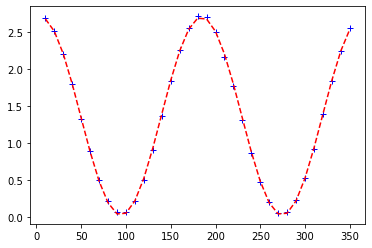

In [24]:
param_0 = [1.4, 0.3, 180*degrees*np.random.rand(1)[0]]
bounds = ([0, 0, 0], [9, 9, 180*degrees])
param_illum = Analizar_medidas(angulos3, P3, fun_err=error_cos2, fun_plot=cos2, param_0=param_0, bounds=bounds)